In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_raw = pd.read_csv('data/historical_update.csv')

## general info

In [3]:
df_raw.shape

(393969, 24)

In [4]:
df_raw.iloc[:,:12].head()

,person_id,Age_at_visit,patient_city,patient_county,patient_zipcode,hospital_poc,Hospital_visit_date,discharge_date,encounter_type,diagnosis_code,dianosis_description,diagnosis_sequence
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,36,AUSTIN,Travis,78754,Brackenridge Hospital,2013-12-06 00:00:00,2013-12-13 18:07:00,Inpatient,860,TRAUM PNEUMOTHORAX-CLOSE,4.0
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,40,AUSTIN,Travis,78754,Brackenridge Hospital,2017-05-05 00:00:00,2017-05-05 14:23:00,Emergency Room,R42,Dizziness and giddiness,2.0
2,000168EA-BC74-4035-B5A6-C92163F8CE62,22,Austin,Travis,78744,Seton Northwest,2016-11-22 00:00:00,2016-11-24 10:00:00,Inpatient,Z37.0,Single live birth,2.0
3,000168EA-BC74-4035-B5A6-C92163F8CE62,23,Austin,Travis,78744,Seton Southwest,2017-03-18 00:00:00,NaN,Emergency Room,G89.18,Other acute postprocedural pain,1.0
4,000168EA-BC74-4035-B5A6-C92163F8CE62,23,Austin,Travis,78744,Seton Southwest,2017-03-12 00:00:00,NaN,Emergency Room,L53.9,"Erythematous condition, unspecified",3.0


In [5]:
df_raw.iloc[:,12:].head()

,payor_name,last community care location,last community care visit date,ethnicity,language,uds ethnicity,uds race,uds homless,LACE L score,LACE A score,LACE E score,Total LACE score
0,Unknown,CUC North Central,2017-03-29 00:00:00,Not Hispanic Or Latino,English,NaN,NaN,Not Homeless,0,0,1,1
1,Self Pay_SFS,CUC North Central,2017-03-29 00:00:00,Not Hispanic Or Latino,English,NaN,NaN,Not Homeless,0,0,1,1
2,Medicaid,CUC SEHWC,2017-09-06 00:00:00,Not Hispanic Or Latino,English,NaN,NaN,Shelter,2,3,2,7
3,Medicaid,CUC SEHWC,2017-09-06 00:00:00,Not Hispanic Or Latino,English,NaN,NaN,Shelter,0,3,2,5
4,Medicaid,CUC SEHWC,2017-09-06 00:00:00,Not Hispanic Or Latino,English,NaN,NaN,Shelter,2,3,2,7


**check if any duplicates**

In [6]:
df_raw.drop_duplicates().shape

(384238, 24)

In [7]:
df_raw = df_raw.drop_duplicates()

## Data types

In [8]:
df_raw.dtypes

person_id                          object
Age_at_visit                        int64
patient_city                       object
patient_county                     object
patient_zipcode                     int64
hospital_poc                       object
Hospital_visit_date                object
discharge_date                     object
encounter_type                     object
diagnosis_code                     object
dianosis_description               object
diagnosis_sequence                float64
payor_name                         object
last community care location       object
last community care visit date     object
ethnicity                          object
language                           object
uds ethnicity                      object
uds race                           object
uds homless                        object
LACE L score                        int64
LACE A score                        int64
LACE E score                        int64
Total LACE score                  

**`Hospital_visit_date`, `discharge_date`, `last community care visit date` are not in `datetime` format.**

In [9]:
df_raw['Hospital_visit_date'] = pd.to_datetime(df_raw['Hospital_visit_date'])
df_raw['discharge_date'] = pd.to_datetime(df_raw['discharge_date'])
df_raw['last community care visit date'] = pd.to_datetime(df_raw['last community care visit date'])

## Re-order dataframe

**sort raw dataframe by `person_id`, `Hospital_visit_date` and `dianosis_seq`**

In [10]:
df_raw_sorted = df_raw.sort_values(by = ['person_id', 'Hospital_visit_date','diagnosis_sequence'])

In [11]:
df_raw_sorted.iloc[:,:12].head()

,person_id,Age_at_visit,patient_city,patient_county,patient_zipcode,hospital_poc,Hospital_visit_date,discharge_date,encounter_type,diagnosis_code,dianosis_description,diagnosis_sequence
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,36,AUSTIN,Travis,78754,Brackenridge Hospital,2013-12-06,2013-12-13 18:07:00,Inpatient,860,TRAUM PNEUMOTHORAX-CLOSE,4.0
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,40,AUSTIN,Travis,78754,Brackenridge Hospital,2017-05-05,2017-05-05 14:23:00,Emergency Room,R42,Dizziness and giddiness,2.0
2,000168EA-BC74-4035-B5A6-C92163F8CE62,22,Austin,Travis,78744,Seton Northwest,2016-11-22,2016-11-24 10:00:00,Inpatient,Z37.0,Single live birth,2.0
5,000168EA-BC74-4035-B5A6-C92163F8CE62,22,Austin,Travis,78744,Seton Northwest,2016-11-22,2016-11-24 10:00:00,Inpatient,Z37.0,Single live birth,2.0
4,000168EA-BC74-4035-B5A6-C92163F8CE62,23,Austin,Travis,78744,Seton Southwest,2017-03-12,NaT,Emergency Room,L53.9,"Erythematous condition, unspecified",3.0


In [12]:
df_raw_sorted.iloc[:,12:].head()

,payor_name,last community care location,last community care visit date,ethnicity,language,uds ethnicity,uds race,uds homless,LACE L score,LACE A score,LACE E score,Total LACE score
0,Unknown,CUC North Central,2017-03-29,Not Hispanic Or Latino,English,NaN,NaN,Not Homeless,0,0,1,1
1,Self Pay_SFS,CUC North Central,2017-03-29,Not Hispanic Or Latino,English,NaN,NaN,Not Homeless,0,0,1,1
2,Medicaid,CUC SEHWC,2017-09-06,Not Hispanic Or Latino,English,NaN,NaN,Shelter,2,3,2,7
5,Medicaid,CUC SEHWC,2017-09-06,Not Hispanic Or Latino,English,NaN,NaN,Shelter,0,3,2,5
4,Medicaid,CUC SEHWC,2017-09-06,Not Hispanic Or Latino,English,NaN,NaN,Shelter,2,3,2,7


**it seems like record 2 and 5 are exactly the same except for LACE score, try to group by `person_id`,`Hospital_visit_date`**

## Inspect same day visit

In [13]:
df_same_date = df_raw_sorted.groupby(['person_id','Hospital_visit_date','diagnosis_code'])[['Total LACE score']].count().reset_index()

In [14]:
df_same_date.head()

,person_id,Hospital_visit_date,diagnosis_code,Total LACE score
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2013-12-06,860,1
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2017-05-05,R42,1
2,000168EA-BC74-4035-B5A6-C92163F8CE62,2016-11-22,Z37.0,2
3,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-12,L53.9,2
4,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-18,G89.18,2


In [15]:
df_same_date['Total LACE score'].value_counts()

1     128391
2      56139
3      18269
4       7471
5       4187
6       1104
7        456
8         11
10        10
12         1
9          1
Name: Total LACE score, dtype: int64

**there exists same day, same diagnosis visit with up to 12 records, let's take a look at it**

In [16]:
df_same_date[df_same_date['Total LACE score'] == 12]

,person_id,Hospital_visit_date,diagnosis_code,Total LACE score
165533,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,12


In [17]:
df_raw_sorted[df_raw_sorted['person_id'] == 'C4ECE685-7941-42A3-8372-0D45CFB29CBC'][df_raw_sorted['diagnosis_code']=='F17.200'][['person_id','Hospital_visit_date','diagnosis_code','diagnosis_sequence','LACE L score','LACE A score','LACE E score','Total LACE score']]

,person_id,Hospital_visit_date,diagnosis_code,diagnosis_sequence,LACE L score,LACE A score,LACE E score,Total LACE score
301857,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,2,3,4,9
301868,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,1,3,4,8
301869,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,0,3,4,7
301870,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,3,3,4,10
301885,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,0,3,4,7
301886,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,3,3,4,10
301888,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,2,3,4,9
301923,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,2.0,1,3,4,8
301867,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,3.0,3,3,4,10
301899,C4ECE685-7941-42A3-8372-0D45CFB29CBC,2017-04-26,F17.200,3.0,0,3,4,7


**as shown above, these 12 records account for same encounter (same patient same date same diagnosis) but 2 different diagnosis sequence and 4 differenct LACE score. To make sure the records does not contains duplicate like this, we decided to drop all the duplicated records and only keep the last one (which means we assume this is a data entry issue).**

In [18]:
df_raw_sorted.drop_duplicates(subset=['person_id','Hospital_visit_date','diagnosis_code'],keep='last').shape

(232126, 24)

In [36]:
df_clean = df_raw_sorted.drop_duplicates(subset=['person_id','Hospital_visit_date','diagnosis_code'],keep='last')

### Excluding only admission (OA)

In [37]:
df_clean_oa = df_clean.groupby(['person_id'])[['Hospital_visit_date']].count().reset_index()

In [38]:
df_clean_oa.columns = ['person_id','admission_count']

In [39]:
df_clean = df_clean.merge(df_clean_oa, on = 'person_id')

In [40]:
df_clean = df_clean[df_clean.admission_count != 1]

In [41]:
df_clean.loc[df_clean['discharge_date'].isnull(),'discharge_date'] = df_clean['Hospital_visit_date']

## Get historical hospital visits (in past year)

In [44]:
#CHANGED
df_clean_same_date = df_clean.groupby(['person_id','Hospital_visit_date','encounter_type'])['Total LACE score'].count().reset_index().drop(['Total LACE score'],axis = 1)

In [45]:
df_clean_same_date.head()

,person_id,Hospital_visit_date,encounter_type
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2013-12-06,Inpatient
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2017-05-05,Emergency Room
2,000168EA-BC74-4035-B5A6-C92163F8CE62,2016-11-22,Inpatient
3,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-12,Emergency Room
4,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-18,Emergency Room


In [46]:
#set visit date as index
df_clean_same_date.set_index(pd.DatetimeIndex(df_clean_same_date['Hospital_visit_date']), inplace=True)
df_clean_same_date.drop('Hospital_visit_date', axis = 1, inplace = True)

In [47]:
df_clean_same_date['count'] = 1

In [48]:
df_clean_same_date.head()

,person_id,encounter_type,count
Hospital_visit_date,,,
2013-12-06,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,Inpatient,1
2017-05-05,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,Emergency Room,1
2016-11-22,000168EA-BC74-4035-B5A6-C92163F8CE62,Inpatient,1
2017-03-12,000168EA-BC74-4035-B5A6-C92163F8CE62,Emergency Room,1
2017-03-18,000168EA-BC74-4035-B5A6-C92163F8CE62,Emergency Room,1


In [49]:
df_rolling = df_clean_same_date.groupby(['person_id'])['count'].apply(pd.rolling_count, 365).reset_index()

In [50]:
df_rolling['count'] = df_rolling['count'].apply(lambda x: x-1)
df_rolling.head()

,Hospital_visit_date,count
0,2013-12-06,0.0
1,2017-05-05,1.0
2,2016-11-22,0.0
3,2017-03-12,1.0
4,2017-03-18,2.0


In [51]:
df_rolling_ER = df_clean_same_date[df_clean_same_date['encounter_type'] == 'Emergency Room'].groupby(['person_id'])['count'].apply(pd.rolling_count, 365).reset_index()

In [52]:
df_rolling_ER['count'] = df_rolling_ER['count'].apply(lambda x: x-1)
df_rolling_ER.head()

,Hospital_visit_date,count
0,2017-05-05,0.0
1,2017-03-12,0.0
2,2017-03-18,1.0
3,2013-09-16,0.0
4,2014-01-30,1.0


In [53]:
df_rolling_IP = df_clean_same_date[df_clean_same_date['encounter_type'] == 'Inpatient'].groupby(['person_id'])['count'].apply(pd.rolling_count, 365).reset_index()

In [54]:
df_rolling_IP['count'] = df_rolling_IP['count'].apply(lambda x: x-1)
df_rolling_IP.head()

,Hospital_visit_date,count
0,2013-12-06,0.0
1,2016-11-22,0.0
2,2017-09-22,0.0
3,2016-06-03,0.0
4,2017-07-05,1.0


In [55]:
df_clean_same_date['past_visits_total'] = df_rolling['count'].tolist()
df_clean_same_date['past_visits_ER'] = 0
df_clean_same_date['past_visits_ER'][df_clean_same_date['encounter_type'] == 'Emergency Room'] = df_rolling_ER['count'].tolist()
df_clean_same_date['past_visits_IP'] = 0
df_clean_same_date['past_visits_IP'][df_clean_same_date['encounter_type'] == 'Inpatient'] = df_rolling_IP['count'].tolist()

In [56]:
df_clean_same_date.drop('count',axis = 1, inplace = True)
df_clean_same_date.head()

,person_id,encounter_type,past_visits_total,past_visits_ER,past_visits_IP
Hospital_visit_date,,,,,
2013-12-06,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,Inpatient,0.0,0.0,0.0
2017-05-05,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,Emergency Room,1.0,0.0,0.0
2016-11-22,000168EA-BC74-4035-B5A6-C92163F8CE62,Inpatient,0.0,0.0,0.0
2017-03-12,000168EA-BC74-4035-B5A6-C92163F8CE62,Emergency Room,1.0,0.0,0.0
2017-03-18,000168EA-BC74-4035-B5A6-C92163F8CE62,Emergency Room,2.0,1.0,0.0


In [57]:
# get correct past_ER and past_IP
def get_past_ER(row):
    if row['encounter_type'] == 'Inpatient':
        return (row['past_visits_total'] - row['past_visits_IP'])
    else:
        return (row['past_visits_ER'])
def get_past_IP(row):
    if row['encounter_type'] == 'Emergency Room':
        return (row['past_visits_total'] - row['past_visits_ER'])
    else:
        return (row['past_visits_IP'])
df_clean_same_date['past_visits_ER'] = df_clean_same_date.apply(get_past_ER, axis=1)
df_clean_same_date['past_visits_IP'] = df_clean_same_date.apply(get_past_IP, axis=1)

## Find future/previous admissions (ALL)

In [151]:
df_clean_all = df_clean.drop_duplicates(subset=['person_id','Hospital_visit_date']).drop(['diagnosis_code','diagnosis_sequence','dianosis_description'],axis = 1)

In [152]:
##Shift time
df_clean_all["encounter_next"] = df_clean_all["encounter_type"].shift(-1)
df_clean_all["Hospital_visit_next"] = df_clean_all["Hospital_visit_date"].shift(-1)
df_clean_all["hospital_poc_next"] = df_clean_all["hospital_poc"].shift(-1)
df_clean_all["person_id_next"] = df_clean_all["person_id"].shift(-1)

df_clean_all["encounter_prev"] = df_clean_all["encounter_type"].shift(1)
df_clean_all["Hospital_visit_prev"] = df_clean_all["discharge_date"].shift(1)
df_clean_all["hospital_poc_prev"] = df_clean_all["hospital_poc"].shift(1)
df_clean_all["person_id_prev"] = df_clean_all["person_id"].shift(1)

In [154]:
def get_encounter_prev(row):
    if(row['person_id']!=row['person_id_prev']):
        return("NA")
    else:
        return(row['encounter_prev'])
def get_hospital_prev(row):
    if(row['person_id']!=row['person_id_prev']):
        return("NA")
    else:
        return(row['Hospital_visit_prev'])
    
def get_poc_prev(row):
    if(row['person_id']!=row['person_id_prev']):
        return("NA")
    else:
        return(row['hospital_poc_prev'])

def get_encounter_next(row):
    if(row['person_id']!=row['person_id_next']):
        return("NA")
    else:
        return(row['encounter_next'])

def get_hospital_next(row):
    if(row['person_id']!=row['person_id_next']):
        return("NA")
    else:
        return(row['Hospital_visit_next'])

def get_poc_next(row):
    if(row['person_id']!=row['person_id_next']):
        return("NA")
    else:
        return(row['hospital_poc_next'])
    
df_clean_all['encounter_prev'] = df_clean_all.apply(get_encounter_prev,axis =1)
df_clean_all['Hospital_visit_prev'] = df_clean_all.apply(get_hospital_prev,axis =1)
df_clean_all['hospital_poc_prev'] = df_clean_all.apply(get_poc_prev,axis =1)
df_clean_all['encounter_next'] = df_clean_all.apply(get_encounter_next,axis =1)
df_clean_all['Hospital_visit_next'] = df_clean_all.apply(get_hospital_next,axis =1)
df_clean_all['hospital_poc_next'] = df_clean_all.apply(get_poc_next,axis =1)

In [155]:
##Get interval from last visit & next visit
def get_interval_prev(row):
    if(row['person_id']==row['person_id_prev']):
        return((row['Hospital_visit_date']-row['Hospital_visit_prev']).days)
    return("NA")
df_clean_all['interval_prev'] = df_clean_all.apply(get_interval_prev,axis =1)

def get_interval_next(row):
    if(row['person_id']==row['person_id_next']):
        return((row['Hospital_visit_next']-row['discharge_date']).days)
    return("NA")
df_clean_all['interval_next'] = df_clean_all.apply(get_interval_next,axis =1)

In [185]:
df_clean_all[['person_id','Hospital_visit_date','discharge_date','Hospital_visit_prev']].head()

,person_id,Hospital_visit_date,discharge_date,Hospital_visit_prev
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2013-12-06,2013-12-13 18:07:00,NA
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2017-05-05,2017-05-05 14:23:00,2013-12-13 18:07:00
2,000168EA-BC74-4035-B5A6-C92163F8CE62,2016-11-22,2016-11-24 10:00:00,NA
3,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-12,2017-03-12 00:00:00,2016-11-24 10:00:00
4,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-18,2017-03-18 00:00:00,2017-03-12 00:00:00


In [156]:
df_clean_all['transfer_in_IP'] = 0
df_clean_all['transfer_in_ER'] = 0
df_clean_all['transfer_out_IP'] = 0
df_clean_all['transfer_out_ER'] = 0

In [157]:
#transfers out
df_clean_all['transfer_out_ER'][((df_clean_all['interval_next'] == 0) | (df_clean_all['interval_next'] == 1)) & (df_clean_all['encounter_next'] == 'Emergency Room')] = 1
df_clean_all['transfer_out_IP'][((df_clean_all['interval_next'] == 0) | (df_clean_all['interval_next'] == 1)) & (df_clean_all['encounter_next'] == 'Inpatient')] = 1

In [158]:
#transfers in
df_clean_all['transfer_in_ER'][((df_clean_all['interval_prev'] == 0) | (df_clean_all['interval_prev'] == 1))& (df_clean_all['encounter_prev'] == 'Emergency Room')] = 1
df_clean_all['transfer_in_IP'][((df_clean_all['interval_prev'] == 0) | (df_clean_all['interval_prev'] == 1)) &( df_clean_all['encounter_prev'] == 'Inpatient')] = 1

In [193]:
df_clean_all['interval_prev']

0           NA
1         1238
2           NA
3          107
4            6
5           NA
6          135
7           81
8         1084
9           38
10          42
11          NA
12           5
13         108
14          20
15           4
16          NA
17         131
18         103
19         136
20         192
21          24
22         398
23         420
24          NA
25          35
26          58
27         487
28           0
29           2
          ... 
221817      26
221818       2
221819      41
221820     183
221821      NA
221822     267
221823     512
221824       8
221825     552
221826      24
221827      NA
221828     346
221829     746
221830      NA
221831      13
221832       2
221833      38
221834       8
221835      33
221836     234
221837      85
221838      29
221839      29
221840      42
221841      37
221842       4
221843     113
221844      34
221845     239
221846     241
Name: interval_prev, Length: 221847, dtype: object

In [173]:
df_clean_all.transfer_in_ER.value_counts()

0    210352
1     11495
Name: transfer_in_ER, dtype: int64

In [159]:
##Label next ER admission and interval
def future_er(row):
    if(row["person_id"]==row["person_id_next"]):
        if row["encounter_next"]=="Emergency Room":
            if((row["Hospital_visit_next"]-row["discharge_date"]).days >30):
                return(">30")
            else:
                return("<=30")
    return("NO")

##Label next inpatient admission and interval
def future_inpatient(row):
    if(row["person_id"]==row["person_id_next"]):
        if row["encounter_next"]=="Inpatient":
            if((row["Hospital_visit_next"]-row["discharge_date"]).days >30):
                return(">30")
            else:
                return("<=30")
    return("NO")

df_clean_all["Future_ER"]=df_clean_all.apply(future_er,axis =1)
df_clean_all["Future_Inpatient"]=df_clean_all.apply(future_inpatient, axis=1)

In [160]:
df_clean_all["Future_ER"].value_counts()

>30     102913
<=30     66376
NO       52558
Name: Future_ER, dtype: int64

In [161]:
df_clean_all["Future_Inpatient"].value_counts()

NO      197108
>30      13560
<=30     11179
Name: Future_Inpatient, dtype: int64

In [162]:
df_clean_all = df_clean_all.merge(df_clean_same_date.reset_index(), on = ['person_id','Hospital_visit_date','encounter_type'])

In [163]:
df_clean_all.to_csv('data/readmission_all.csv', index = False)

In [164]:
df_clean_all.shape

(221847, 41)

## Create new table for diagnosis

In [116]:
df_diagnosis_code = df_clean.groupby(['person_id','Hospital_visit_date'])['diagnosis_code'].apply(list).reset_index()
df_diagnosis_seq = df_clean.groupby(['person_id','Hospital_visit_date'])['diagnosis_sequence'].apply(list).reset_index()

In [117]:
df_diagnosis_all = df_diagnosis_code.merge(df_diagnosis_seq, on = ['person_id','Hospital_visit_date'])

In [118]:
df_diagnosis_all.head()

,person_id,Hospital_visit_date,diagnosis_code,diagnosis_sequence
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2013-12-06,[860],[4.0]
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2017-05-05,[R42],[2.0]
2,000168EA-BC74-4035-B5A6-C92163F8CE62,2016-11-22,[Z37.0],[2.0]
3,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-12,[L53.9],[3.0]
4,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-18,[G89.18],[1.0]


In [119]:
df_diagnosis_all.to_csv('data/readmission_diagnosis_all.csv', index = False)

In [120]:
df_diagnosis_all.shape

(221847, 4)

## Find future/previous admissions (IP to IP)

### get previous encounter info (ALL)

In [295]:
df_clean_ip = df_clean.drop_duplicates(subset=['person_id','Hospital_visit_date'], keep = 'last').drop(['diagnosis_code','diagnosis_sequence','dianosis_description'],axis = 1)
df_clean_ip.shape

(221847, 22)

In [296]:
df_clean_ip["encounter_prev_all"] = df_clean_ip["encounter_type"].shift(1)
df_clean_ip["Hospital_visit_prev_all"] = df_clean_ip["discharge_date"].shift(1)
df_clean_ip["hospital_poc_prev_all"] = df_clean_ip["hospital_poc"].shift(1)
df_clean_ip["person_id_prev_all"] = df_clean_ip["person_id"].shift(1)

In [297]:
def get_encounter_prev_all(row):
    if(row['person_id']!=row['person_id_prev_all']):
        return("NA")
    else:
        return(row['encounter_prev_all'])
def get_hospital_prev_all(row):
    if(row['person_id']!=row['person_id_prev_all']):
        return("NA")
    else:
        return(row['Hospital_visit_prev_all'])
    
def get_poc_prev_all(row):
    if(row['person_id']!=row['person_id_prev_all']):
        return("NA")
    else:
        return(row['hospital_poc_prev_all'])


df_clean_ip['encounter_prev_all'] = df_clean_ip.apply(get_encounter_prev_all,axis =1)
df_clean_ip['Hospital_visit_prev_all'] = df_clean_ip.apply(get_hospital_prev_all,axis =1)
df_clean_ip['hospital_poc_prev_all'] = df_clean_ip.apply(get_poc_prev_all,axis =1)

In [298]:
##Get interval from last visit (ALL)
def get_interval_prev_all(row):
    if(row['person_id']==row['person_id_prev_all']):
        return((row['Hospital_visit_date']-row['Hospital_visit_prev_all']).days)
    return("NA")
df_clean_ip['interval_prev_all'] = df_clean_ip.apply(get_interval_prev_all,axis =1)

In [299]:
df_clean_ip['transfer_in_ER'] = 0
df_clean_ip['transfer_in_IP'] = 0

In [300]:
#transfers in
df_clean_ip['transfer_in_ER'][((df_clean_ip['interval_prev_all'] == 0) | (df_clean_ip['interval_prev_all'] == 1))& (df_clean_ip['encounter_prev_all'] == 'Emergency Room')] = 1
df_clean_ip['transfer_in_IP'][((df_clean_ip['interval_prev_all'] == 0) | (df_clean_ip['interval_prev_all'] == 1)) &( df_clean_ip['encounter_prev_all'] == 'Inpatient')] = 1

In [301]:
df_clean_ip.transfer_in_ER.value_counts()

0    210353
1     11494
Name: transfer_in_ER, dtype: int64

### Inpatient only encounters

In [302]:
df_clean_ip = df_clean_ip[df_clean_ip['encounter_type'] == 'Inpatient']
df_clean_ip.shape

(29107, 29)

In [303]:
##Shift time
df_clean_ip["encounter_next"] = df_clean_ip["encounter_type"].shift(-1)
df_clean_ip["Hospital_visit_next"] = df_clean_ip["Hospital_visit_date"].shift(-1)
df_clean_ip["hospital_poc_next"] = df_clean_ip["hospital_poc"].shift(-1)
df_clean_ip["person_id_next"] = df_clean_ip["person_id"].shift(-1)

df_clean_ip["encounter_prev"] = df_clean_ip["encounter_type"].shift(1)
df_clean_ip["Hospital_visit_prev"] = df_clean_ip["discharge_date"].shift(1)
df_clean_ip["hospital_poc_prev"] = df_clean_ip["hospital_poc"].shift(1)
df_clean_ip["person_id_prev"] = df_clean_ip["person_id"].shift(1)

In [304]:
df_clean_ip['encounter_prev'] = df_clean_ip.apply(get_encounter_prev,axis =1)
df_clean_ip['Hospital_visit_prev'] = df_clean_ip.apply(get_hospital_prev,axis =1)
df_clean_ip['hospital_poc_prev'] = df_clean_ip.apply(get_poc_prev,axis =1)

df_clean_ip['encounter_next'] = df_clean_ip.apply(get_encounter_next,axis =1)
df_clean_ip['Hospital_visit_next'] = df_clean_ip.apply(get_hospital_next,axis =1)
df_clean_ip['hospital_poc_next'] = df_clean_ip.apply(get_poc_next,axis =1)

In [305]:
##Get interval from last and next INPATIENT visit
df_clean_ip['interval_prev'] = df_clean_ip.apply(get_interval_prev,axis =1)
df_clean_ip['interval_next'] = df_clean_ip.apply(get_interval_next,axis =1)

In [306]:
#transfers out
df_clean_ip['transfer_out_IP'] = 0
df_clean_ip['transfer_out_IP'][((df_clean_ip['interval_next'] == -1) | (df_clean_ip['interval_next'] == 0) | (df_clean_ip['interval_next'] == 1) ) & (df_clean_ip['encounter_next'] == 'Inpatient')] = 1

In [307]:
df_clean_ip['transfer_out_IP'].value_counts()

0    28293
1      814
Name: transfer_out_IP, dtype: int64

In [308]:
##Label next INPAITIENT admission and interval
df_clean_ip["Future_Inpatient"]=df_clean_ip.apply(future_inpatient, axis=1)

In [309]:
df_clean_ip["Future_Inpatient"].value_counts()

NO      12871
>30     11295
<=30     4941
Name: Future_Inpatient, dtype: int64

In [310]:
df_clean_ip.head()

,person_id,Age_at_visit,patient_city,patient_county,patient_zipcode,hospital_poc,Hospital_visit_date,discharge_date,encounter_type,payor_name,...,hospital_poc_next,person_id_next,encounter_prev,Hospital_visit_prev,hospital_poc_prev,person_id_prev,interval_prev,interval_next,transfer_out_IP,Future_Inpatient
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,36,AUSTIN,Travis,78754,Brackenridge Hospital,2013-12-06,2013-12-13 18:07:00,Inpatient,Unknown,...,NA,000168EA-BC74-4035-B5A6-C92163F8CE62,NA,NA,NA,NaN,NA,NA,0,NO
2,000168EA-BC74-4035-B5A6-C92163F8CE62,22,Austin,Travis,78744,Seton Northwest,2016-11-22,2016-11-24 10:00:00,Inpatient,Medicaid,...,NA,0003E5CA-4E3A-4D93-AEC2-12B62404D098,NA,NA,NA,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,NA,NA,0,NO
15,0003E5CA-4E3A-4D93-AEC2-12B62404D098,53,AUSTIN,Travis,78758,St. Davids South Austin Medical Center,2017-09-22,2017-09-27 19:03:00,Inpatient,Charity,...,NA,000D4C90-4826-4B44-A6F7-E2290E39F2FC,NA,NA,NA,000168EA-BC74-4035-B5A6-C92163F8CE62,NA,NA,0,NO
73,000D4C90-4826-4B44-A6F7-E2290E39F2FC,23,Austin,Travis,78741,Seton Medical Center,2016-06-03,2016-06-06 18:50:00,Inpatient,Medicaid,...,Seton Medical Center,000D4C90-4826-4B44-A6F7-E2290E39F2FC,NA,NA,NA,0003E5CA-4E3A-4D93-AEC2-12B62404D098,NA,393,0,>30
75,000D4C90-4826-4B44-A6F7-E2290E39F2FC,24,Austin,Travis,78741,Seton Medical Center,2017-07-05,2017-07-08 18:10:00,Inpatient,Medicaid,...,NA,000DD9EF-6B0B-4656-83AB-981FC7F142D8,Inpatient,2016-06-06 18:50:00,Seton Medical Center,000D4C90-4826-4B44-A6F7-E2290E39F2FC,393,NA,0,NO


In [311]:
df_clean_ip = df_clean_ip.merge(df_clean_same_date.reset_index(), on = ['person_id','Hospital_visit_date','encounter_type'], how = 'left')

In [312]:
df_clean_ip.to_csv('data/readmission_ip.csv', index = False)

In [313]:
df_clean_ip.shape

(29107, 44)

## Create new table for diagnosis (IP)

In [275]:
df_diagnosis_code = df_clean.groupby(['person_id','Hospital_visit_date'])['diagnosis_code'].apply(list).reset_index()
df_diagnosis_seq = df_clean.groupby(['person_id','Hospital_visit_date'])['diagnosis_sequence'].apply(list).reset_index()

In [270]:
df_diagnosis_filter = df_clean.groupby(['person_id','Hospital_visit_date'])['encounter_type'].apply(list).reset_index()
df_diagnosis_filter['is_IP'] = df_diagnosis_filter['encounter_type'].apply(lambda x: eval(str(x))[-1] == 'Inpatient')
df_diagnosis_filter_ip = df_diagnosis_filter[df_diagnosis_filter.is_IP == True]

In [276]:
df_diagnosis_code = df_diagnosis_code.merge(df_diagnosis_filter_ip, on = ['person_id','Hospital_visit_date'], how = 'right').drop(['encounter_type','is_IP'], axis = 1)
df_diagnosis_seq = df_diagnosis_seq.merge(df_diagnosis_filter_ip, on = ['person_id','Hospital_visit_date'], how = 'right').drop(['encounter_type','is_IP'], axis = 1)

In [277]:
df_diagnosis_ip = df_diagnosis_code.merge(df_diagnosis_seq, on = ['person_id','Hospital_visit_date'])

In [278]:
df_diagnosis_ip.head()

,person_id,Hospital_visit_date,diagnosis_code,diagnosis_sequence
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2013-12-06,[860],[4.0]
1,000168EA-BC74-4035-B5A6-C92163F8CE62,2016-11-22,[Z37.0],[2.0]
2,0003E5CA-4E3A-4D93-AEC2-12B62404D098,2017-09-22,[nan],[nan]
3,000D4C90-4826-4B44-A6F7-E2290E39F2FC,2016-06-03,[O70.0],[3.0]
4,000D4C90-4826-4B44-A6F7-E2290E39F2FC,2017-07-05,[O71.89],[3.0]


In [279]:
df_diagnosis_ip.shape

(29107, 4)

In [280]:
df_diagnosis_ip.to_csv('data/readmission_diagnosis_ip.csv', index = False)

## Find future/previous admissions (ER to ER)

In [67]:
df_clean_er = df_clean[df_clean['encounter_type'] == 'Emergency Room'].drop_duplicates(subset=['person_id','Hospital_visit_date']).drop(['diagnosis_code','diagnosis_sequence','dianosis_description'],axis = 1)
df_clean_er.shape

(198314, 21)

In [68]:
##Shift time
df_clean_er["encounter_next"] = df_clean_er["encounter_type"].shift(-1)
df_clean_er["Hospital_visit_next"] = df_clean_er["Hospital_visit_date"].shift(-1)
df_clean_er["person_id_next"] = df_clean_er["person_id"].shift(-1)

df_clean_er["encounter_prev"] = df_clean_er["encounter_type"].shift(1)
df_clean_er["Hospital_visit_prev"] = df_clean_er["discharge_date"].shift(1)
df_clean_er["person_id_prev"] = df_clean_er["person_id"].shift(1)

In [69]:
df_clean_er['encounter_prev'] = df_clean_er.apply(get_encounter_prev,axis =1)
df_clean_er['Hospital_visit_prev'] = df_clean_er.apply(get_hospital_prev,axis =1)
df_clean_er['encounter_next'] = df_clean_er.apply(get_encounter_next,axis =1)
df_clean_er['Hospital_visit_next'] = df_clean_er.apply(get_hospital_next,axis =1)

In [70]:
##Get interval from last INPATIENT visit
df_clean_er['interval'] = df_clean_er.apply(get_interval,axis =1)

In [71]:
##Label next INPAITIENT admission and interval
df_clean_er["Future_ER"]=df_clean_er.apply(future_er, axis=1)

In [72]:
df_clean_er["Future_ER"].value_counts()

>30     103411
<=30     62389
NO       32514
Name: Future_ER, dtype: int64

In [73]:
df_clean_er.head()

,person_id,Age_at_visit,patient_city,patient_county,patient_zipcode,hospital_poc,Hospital_visit_date,discharge_date,encounter_type,payor_name,...,LACE E score,Total LACE score,encounter_next,Hospital_visit_next,person_id_next,encounter_prev,Hospital_visit_prev,person_id_prev,interval,Future_ER
1,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,40,AUSTIN,Travis,78754,Brackenridge Hospital,2017-05-05,2017-05-05 14:23:00,Emergency Room,Self Pay_SFS,...,1,1,NA,NA,000168EA-BC74-4035-B5A6-C92163F8CE62,NA,NA,NaN,NA,NO
6,000168EA-BC74-4035-B5A6-C92163F8CE62,23,Austin,Travis,78744,Seton Southwest,2017-03-12,2017-03-12 00:00:00,Emergency Room,Medicaid,...,2,5,Emergency Room,2017-03-18 00:00:00,000168EA-BC74-4035-B5A6-C92163F8CE62,NA,NA,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,NA,<=30
7,000168EA-BC74-4035-B5A6-C92163F8CE62,23,Austin,Travis,78744,Seton Southwest,2017-03-18,2017-03-18 00:00:00,Emergency Room,Medicaid,...,2,7,NA,NA,0002D337-B012-40F4-90B1-51E257E2E13C,Emergency Room,2017-03-12 00:00:00,000168EA-BC74-4035-B5A6-C92163F8CE62,6,NO
11,0002D337-B012-40F4-90B1-51E257E2E13C,26,DALE,Caldwell,78616,St. Davids South Austin Medical Center,2013-09-16,2013-09-16 19:42:00,Emergency Room,Self Pay & SFS,...,3,3,Emergency Room,2014-01-30 00:00:00,0002D337-B012-40F4-90B1-51E257E2E13C,NA,NA,000168EA-BC74-4035-B5A6-C92163F8CE62,NA,>30
13,0002D337-B012-40F4-90B1-51E257E2E13C,27,DALE,Caldwell,78616,St. Davids South Austin Medical Center,2014-01-30,2014-01-30 15:40:00,Emergency Room,Self Pay & SFS,...,3,3,Emergency Room,2014-04-22 00:00:00,0002D337-B012-40F4-90B1-51E257E2E13C,Emergency Room,2013-09-16 19:42:00,0002D337-B012-40F4-90B1-51E257E2E13C,135,>30


In [74]:
df_clean_er = df_clean_er.merge(df_clean_same_date.reset_index(), on = ['person_id','Hospital_visit_date','encounter_type'], how = 'left')

In [75]:
df_clean_er.shape

(198314, 32)

In [76]:
df_clean_er.to_csv('data/readmission_er.csv', index = False)

## Create new table for diagnosis (ER)

In [78]:
df_diagnosis_code = df_clean[df_clean['encounter_type'] == 'Emergency Room'].groupby(['person_id','Hospital_visit_date'])['diagnosis_code'].apply(list).reset_index()
df_diagnosis_seq = df_clean[df_clean['encounter_type'] == 'Emergency Room'].groupby(['person_id','Hospital_visit_date'])['diagnosis_sequence'].apply(list).reset_index()

In [79]:
df_diagnosis_er = df_diagnosis_code.merge(df_diagnosis_seq, on = ['person_id','Hospital_visit_date'])

In [80]:
df_diagnosis_er.head()

,person_id,Hospital_visit_date,diagnosis_code,diagnosis_sequence
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2017-05-05,[R42],[2.0]
1,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-12,[L53.9],[3.0]
2,000168EA-BC74-4035-B5A6-C92163F8CE62,2017-03-18,[G89.18],[1.0]
3,0002D337-B012-40F4-90B1-51E257E2E13C,2013-09-16,[786.52],[1.0]
4,0002D337-B012-40F4-90B1-51E257E2E13C,2014-01-30,[789.02],[1.0]


In [81]:
df_diagnosis_er.to_csv('data/readmission_diagnosis_er.csv', index = False)

In [82]:
df_diagnosis_er.shape

(198314, 4)

## icd9 to icd10 crosswalk

In [83]:
df_crosswalk = pd.read_csv('data/icd9_icd10_crosswalk_with_ccs.csv')

In [84]:
df_crosswalk.head()

,dx_cd9,dx_cd9_wo_dec,dx_cd9_description,dx_cd10,dx_cd10_wo_dec,flags,ccs10_category,dx_cd10_description,ccs10_category_description,ccs9_category,ccs9_category_description
0,001,001,CHOLERA,A00,A00,NaN,135.0,Cholera,Intestinal Infection,135.0,Intestinal Infection
1,001.0,0010,CHOLERA DUE TO VIBRIO CHOLERAE,A00.0,A000,0.0,135.0,"Cholera due to Vibrio cholerae 01, biovar chol...",Intestinal Infection,135.0,Intestinal Infection
2,001.1,0011,CHOLERA DUE TO VIBRIO CHOLERAE EL TOR,A00.1,A001,0.0,135.0,"Cholera due to Vibrio cholerae 01, biovar eltor",Intestinal Infection,135.0,Intestinal Infection
3,001.9,0019,"CHOLERA, UNSPECIFIED",A00.9,A009,0.0,135.0,"Cholera, unspecified",Intestinal Infection,135.0,Intestinal Infection
4,002,002,TYPHOID AND PARATYPHOID FEVERS,A01,A01,NaN,135.0,Typhoid and paratyphoid fevers,Intestinal Infection,135.0,Intestinal Infection


In [85]:
df_crosswalk_clean = df_crosswalk[['dx_cd9','dx_cd10','ccs10_category']]

In [86]:
df_crosswalk_code = df_crosswalk_clean.groupby('dx_cd9')['dx_cd10'].apply(list).reset_index()
df_crosswalk_ccs10cat = df_crosswalk_clean.groupby(['dx_cd9'])[['ccs10_category']].agg(lambda x: stats.mode(x)[0][0]).reset_index()

In [87]:
df_crosswalk_icd9ccs = df_crosswalk_code.merge(df_crosswalk_ccs10cat, on = 'dx_cd9')

In [88]:
df_crosswalk_icd9ccs.head()

,dx_cd9,dx_cd10,ccs10_category
0,001,[A00],135.0
1,001.0,[A00.0],135.0
2,001.1,[A00.1],135.0
3,001.9,[A00.9],135.0
4,002,[A01],135.0


In [89]:
df_crosswalk_icd10ccs = df_crosswalk_clean[['dx_cd10','ccs10_category']].groupby(['dx_cd10'])[['ccs10_category']].agg(lambda x: stats.mode(x)[0][0]).reset_index()

In [90]:
df_crosswalk_icd10ccs.head()

,dx_cd10,ccs10_category
0,A00,135.0
1,A00.0,135.0
2,A00.1,135.0
3,A00.9,135.0
4,A01,135.0


In [91]:
df_crosswalk_icd9ccs.to_csv('data/icd_crosswalk_icd9ccs.csv', index = False)
df_crosswalk_icd10ccs.to_csv('data/icd_crosswalk_icd10ccs.csv', index = False)

## A little EDA

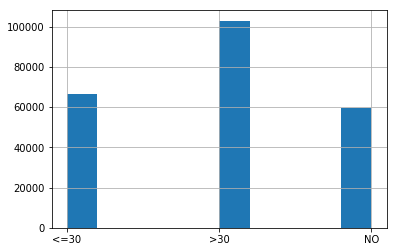

In [92]:
df_clean_all["Future_ER"].hist()

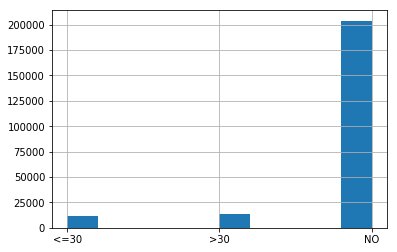

In [93]:
df_clean_all["Future_Inpatient"].hist() #imbalanced

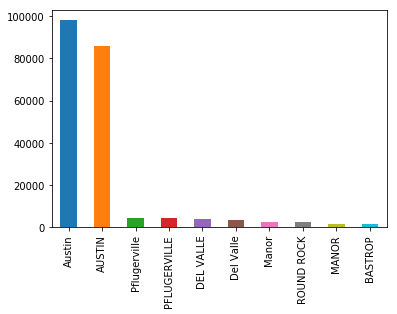

In [94]:
df_clean_all["patient_city"].value_counts()[:10].plot('bar') #city name

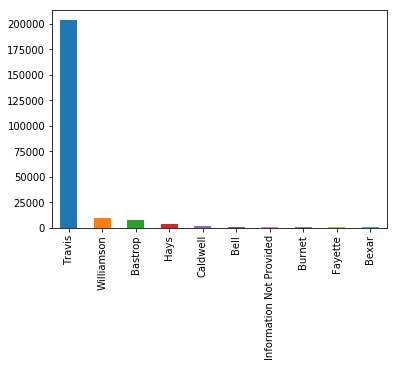

In [95]:
df_clean_all["patient_county"].value_counts()[:10].plot('bar') #city name

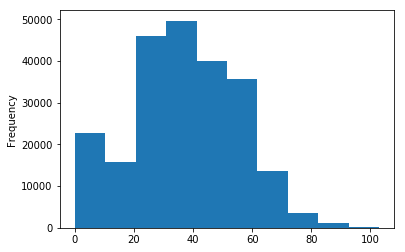

In [96]:
df_clean_all["Age_at_visit"].plot("hist")

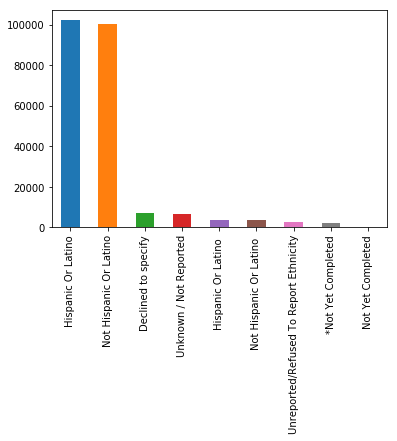

In [97]:
df_clean_all['ethnicity'].value_counts().sort_values(ascending = False)[:10].plot("bar")

In [98]:
#fix patient city name issue
df_clean_all['patient_city'] = df_clean.patient_city.str.capitalize()

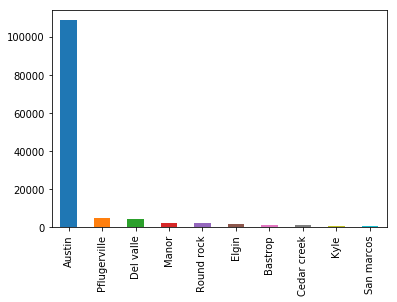

In [99]:
df_clean_all["patient_city"].value_counts()[:10].plot('bar') #city name